In [1]:
import ipywidgets
import scipy.linalg as lin
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load cheb.py
from numpy import *
from numpy.fft import fft,ifft

def cheb(y):
    '''Chebyshev transform. Finds Chebyshev coefficients given y evaluated on
    Chebyshev grid'''
    N = len(y) - 1
    yt = real(fft(r_[y,y[-2:0:-1]]))
    yt = yt/(2*N)
    yt = r_[yt[0],yt[1:N]+yt[-1:N:-1],yt[N]]

    return yt

def icheb(c):
    '''Inverse Chebyshev transform. Evaluates Chebyshev series at the Chebyshev 
    grid points given Chebyshev coefficients.'''
    N = len(c) - 1
    y = r_[c[0],0.5*c[1:N],c[N],0.5*c[-1:N:-1]]
    y = y*2*N
    y = real(ifft(r_[y,y[-2:0:-1]]))[:N+1]

    return y


def Dcheb(y,interval):
    '''Chebyshev derivative of y evaluated on Chebyshev grid in interval [a,b]'''
    N = len(y) - 1
    a,b = interval
    x = 0.5*(b-a)*(cos(r_[0:N+1]*pi/N) + 1) + a

    k = r_[0:N]

    A = real(fft(r_[y,y[-2:0:-1]]))
    yy = real(ifft(1j*r_[k,0,-k[-1:0:-1]]*A))

    fact = 2.*(x-a)/(b-a)-1
    fact = fact[1:-1]
    yprime = -2./(b-a)*yy[1:N]/sqrt(1-fact**2)

    A = A/(2*N)
    A = r_[A[0],A[1:N]+A[-1:N:-1],A[N]]
    k = r_[0:N+1]

    yprime1 = sum(k**2*A)*2./(b-a)
    yprimeN = sum((-1)**(k+1)*k**2*A)*2./(b-a)

    return r_[yprime1,yprime,yprimeN]



def regrid(y,M):
    N = len(y) - 1
    a = cheb(y)
    if M==N:
        return y
    if M>N:
        a = r_[a,zeros(M-N)]
        return icheb(a)
    if M<N:
        a = a[:M+1]
        return icheb(a)



def clenshaw(x,c):
    '''Clenshaw algorithm to evaluate Chebyshev series at x
    assumes x is in [-1,1]'''
    N = len(c) - 1
    b = zeros(N+2)
    b[-1] = 0
    b[-2] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r] = 2*x*b[r+1] - b[r+2] + c[r]
    s = x*b[1] - b[2] + c[0]

    return s


def clenshaw2(x,c,change_grid = True):
    '''Vectorized version of Clenshaw algorithm
    Use this for Chebyshev polynomial evaluation'''
    if change_grid:
    	if (min(x)!=-1) or (max(x)!=1):
        	x = 2*(x-min(x))/(max(x)-min(x)) - 1
    N = len(c) - 1
    b = zeros([N+2,len(x)])
    b[-1,:] = 0
    b[-2,:] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r,:] = 2*x*b[r+1,:] - b[r+2,:] + c[r]
    s = x*b[1,:] - b[2,:] + c[0]

    return s



def chebD(c,interval):
    '''Finds derivative of Chebyshev series in spectral space
    i.e. maps c_n--->d_n where c_n,d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [a,b].'''
    N = len(c) - 1
    a,b = interval
    if (a!=-1.) or (b!=1.):
        factor = 2./(b-a)
    else: 
        factor = 1.

    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    cp = cp*factor

    return cp


def chebD_semiinf(c):
    '''Finds the derivative of Chebyshev series in spectral space
    i.e. maps c_n --> d_n where c_n, d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [0,oo)'''
    '''To be used only for the positive half-line'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = 3./4*cp[0] - cp[1]/2. + cp[2]/8.
    d1 = -cp[0] + 7./8*cp[1] - cp[2]/2. + cp[3]/8.
    d2 = cp[0]/4. - cp[1]/2. + 3./4*cp[2] - cp[3]/2. + cp[4]/8.
    d3 = cp[1]/8. - cp[2]/2. + 3./4*cp[3] - cp[4]/2. + cp[5]/8.
    
    dn = [ cp[i-2]/8. - cp[i-1]/2. + 3./4*cp[i] - cp[i+1]/2. + cp[i+2]/8.  for i in range(4,N-1)]

    dn1 = cp[N-1-2]/8. - cp[N-1-1]/2. + 3./4*cp[N-1] - cp[N-1+1]/2.
    
    dn2 = cp[N-2]/8. - cp[N-1]/2. + 3./4*cp[N]
    
    dn = r_[d0,d1,d2,d3,dn,dn1,dn2]

    return dn


def cheb2zD_semiinf(c):
    '''Finds the Chebyshev coefficients of the operator 2z df/dz when
    f has a series in Chebyshev rational functions Rn(z) = Tn((z-1)/(z+1)). Input
    is the coefficients of f.'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = -cp[2]/4. + cp[0]/2.
    d1 = cp[1]/4. - cp[3]/4.
    d2 = -cp[0]/2. + cp[2]/2. - cp[4]/4.
    
    dn = [ -cp[n-2]/4.  + cp[n]/2. - cp[n+2]/4 for n in range(3,N-1)] 
    
    dn1 = -cp[N-3]/4. + cp[N-1]/2
    dn2 = -cp[N-2]/4. + cp[N]/2
    
    dn = r_[d0,d1,d2,dn,dn1,dn2]
    
    return dn



def Intcheb(y,interval):
    '''Clenshaw-Curtis to find definite integral of function y(x) given at
    Chebyshev grid points in some interval [a,b]'''
    fact = 0.5*(interval[1]-interval[0])
    b = cheb(y)
    N = len(y) - 1
    if N%2 == 0:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:N/2+1]])
    else:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:(N-1)/2+1]])
    return dot(b[::2],w)*fact



def chebI(c,interval,x0=None,f0=None):
    if x0==None:
        x0=interval[0]

    N = len(c) - 1
    I = diag(1./(2*r_[0.5,r_[2:N+1]]),-1) -diag(1./(2*r_[1,r_[1:N]]),1)
    I[0,1] = 0
    
    factor = (interval[1]-interval[0])/2.
    
    ci = dot(I,c)*factor
    x = 2*(x0-interval[0])/(interval[1]-interval[0]) - 1
    
    if x==-1 and f0==None:
        ci[0] = -sum((-1)**r_[1:N+1]*ci[1:])
    else:
        ci[0] = f0 - clenshaw(x,ci)
    return ci



def cheb_convolve(a,b):
    '''Finds the product of two functions whose Chebyshev coefficients are 
    given by a and b. Output is the coefficiets of the product.'''

    M = len(b)
    N = len(a)
    
    if N>M:
        b = r_[b,zeros(N-M)]
        N = N - 1
    elif M>N:
        a = r_[a,zeros(M-N)]
        N = M - 1
    else:
        N = N - 1
    
    a[0] = a[0]*2.
    b[0] = b[0]*2.
        
    c0 = a[0]*b[0] + 2*dot(a[1:],b[1:])
    
    c1 = [ dot(a[0:k+1][::-1],b[0:k+1]) + dot(a[1:N-k+1],b[k+1:N+1]) + dot(a[k+1:N+1],b[1:N-k+1])  for k in range(1,N) ]

    c2 = [ dot(a[k-N:N+1][::-1],b[k-N:N+1])  for k in range(N,2*N+1)]
    
    c = r_[c0/2,c1,c2]/2.
    
    return c[:N+1]
    
def cosT(d,inverse=False):
    '''Finds the cosine transform of a given sequence'''
    b = []
    N = len(d)-1
    for n in r_[0:N+1]:
        b.append(sum(d*cos(n*r_[0:N+1]*pi/N)))
    b = array(b)
    if inverse:
        return b
    else:
        b[0] = b[0]/(N)
        b[1:] = b[1:]*2/(N)
        return b

### The alternate method

We assume 
$$ \sum_n c_n R_n = \frac{1}{(1+x)^2} \sum_n b_n R_n $$

alt_matrix and nate_matrix are used to construct the $ b_n $ s from $ R_n $ s

In [3]:
def alt_matrix(N):
    if N < 5:
        print("Make N >= 5")
    else:
        t0,t1,t1=3/4,1/2,1/8
        A = np.zeros((N,N))
        A[0,0] = 1/16
        A[1,0:2] = [-1/4,1/16]
        A[2,0:3] = [3/8,-1/4,1/16]
        A[3,0:4] = [-1/4,3/8,-1/4,1/16]
        A[4,0:5] = [1/16,-1/4,3/8,-1/4,1/16]
        for i in range(5,N):
            A[i,i-4:i+1] = [1/16,-1/4,3/8,-1/4,1/16]
        A[-1,-5:] = [1/16,-1/4,3/8,-1/4,1/8]
        return A

def nate_matrix(N):
    M = zeros((N,N))
    K =[16,64,160,320,560]
    d = [-1,4,-6,4]
    for i in range(N):
        K = K+[dot(d,K[-4:])]
        M = M + K[i]*eye(N,N,-i)
    M[-1,:]=0.5*M[-1,:]   
    return M

In [4]:
def integrator(c,b=[]):
    a0 = sum(c)
    a1 = sum(-(chebD(c,[-1,1]))*2)
    r = c[2:]
    rc = r[::-1]
    #rc[rc<0.001]=0
    A = nate_matrix(len(rc))
    #ra = solve(A,rc)
    ra = np.dot(A,rc)
    a = ra[::-1]
    a=a/2
    Int = chebI(a,[-1,1],-1,0)
    b = [a0,a1] +b
    return Int,b

def alligrator(c,M,b=[]):
    a0 = sum(c)
    a1 = sum(-(chebD(c,[-1,1]))*2)
    #r =zeros(len(c))
    r = c[2:]
    rc = r[::-1]
    ra = np.dot(M,rc)
    a = ra[::-1]
    a=a/2
    Int = chebI(a,[-1,1],-1,0)
    b = [a0,a1] +b
    return Int,b

def basis(N):
    A=np.eye(N)
    B=np.zeros((N-2,N))
    M=nate_matrix(N-2)
    i=0
    for row in A:
        B[:,i],k= alligrator(row,M)
        i+=1
    return B

$ f_x = g $

$ f(x)-f(0) = \int_0^x g(s) ds $

$ \bar{f} = \mathbb{I} g $

In [5]:
def derivmatrix(N, interval=[-1,1]):
    A=np.eye(N)
    B=np.zeros((N,N))
    i=0
    for row in A:
        B[i,:]= Dcheb(row,interval)
        i+=1
    T=B.transpose() 
    return T

In [14]:
A = [[1,2,3],[3,4,5]]
sum(A)
t = ones(2)
f =dot(t,A)
r_[A,[f]]

array([[ 1.,  2.,  3.],
       [ 3.,  4.,  5.],
       [ 4.,  6.,  8.]])

In [13]:
N = 50
T = basis(N)
c1 = np.ones(N)
D = derivmatrix(N)
c2 = np.dot(c1,D)
I = r_[T,[c1],[c2]]


In [14]:
size(I,1)

50

I is the matrix we want. But, it might not be invertible. Taking the determinant,

In [15]:
lin.det(I)

7.368455885374967e-40

That's pretty much zero so, it isn't invertible.

In [9]:
It = np.transpose(I)
A = np.dot(I,It)
lin.det(A)

9.188793387472161e-60

In [18]:
N=50
z=np.cos(np.pi*np.linspace(0,N-1,N)/N-1)
L = 1
x = L*((z[1:]+1)/(1-z[1:]))
x = r_[inf,x]
y = x**2
y[-1]=0
y[-2]=0
pI = lin.pinv(I) #pseudoinverse
ans = np.dot(pI,y)
#ans = lin.solve(I,y)

In [43]:
x

array([  3.35068530e+00,   3.90283252e+00,   4.57889611e+00,
         5.41865015e+00,   6.47923688e+00,   7.84512961e+00,
         9.64546143e+00,   1.20856707e+01,   1.55087683e+01,
         2.05227394e+01,   2.82902887e+01,   4.12688875e+01,
         6.54230219e+01,   1.18533784e+02,   2.75479426e+02,
         1.20822943e+03,   1.41881673e+05,   8.60796321e+02,
         2.32515116e+02,   1.05828932e+02,   6.00669458e+01,
         3.85275243e+01,   2.67041987e+01,   1.95240972e+01,
         1.48398774e+01,   1.16159870e+01,   9.30315337e+00,
         7.58803659e+00,   6.28129707e+00,   5.26305273e+00,
         4.45440466e+00,   3.80170623e+00,   3.26745122e+00,
         2.82477939e+00,   2.45404649e+00,   2.14061770e+00,
         1.87340999e+00,   1.64390640e+00,   1.44547537e+00,
         1.27289183e+00,   1.12199450e+00,   9.89436838e-01,
         8.72503518e-01,   7.68973443e-01,   6.77016304e-01,
         5.95113600e-01,   5.21997748e-01,   4.56604694e-01,
         3.98036727e-01,

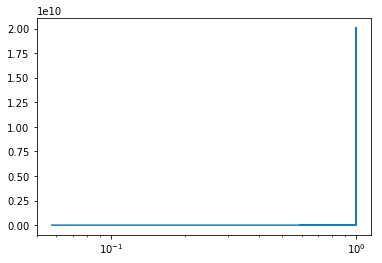

In [20]:
ansr = icheb(ans)
semilogx(z,y)